# По мотивам Memology - DataScience & Memes

## Домашнее задание
### Практический проект по предсказанию рейтинга фильма.
Цель: В этом задании вам предстоит поработать с методом tf-idf чтобы извлечь признаки из текста для построения моделей.
1. Скачайте данные по отзывам с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

2. Разбейте данные на train/test, отложив 30% наблюдений для тестирования (датасет достаточно большой и выборка сбалансированная, так что можно не беспокоиться о стратификации)

3. Примените tf-idf преобразование. Используйте как отдельные токены, так и биграммы, отсейте английские стоп-слова, а также слова, которые встречаются реже, чем в двух отзывах, или чаще, чем в 50% отзывов (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена

4. Постройте логистическую регрессию с настройкой параметра регуляризации, оцените качество при помощи метрик для бинарной классификации

5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Какие слова наиболее характерны для отрицательных отзывов? Какие для положительных?


__Критерии оценки:__ 
* Предобработка текста в tf-idf - 6 баллов 
* Логит регрессия с оценкой качества - 2 балла
* Визуализация коэффициентов - 2 балла

_Рекомендуем сдать до: 10.02.2020_ 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
#import json

In [2]:
import seaborn as sn
from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

###  Часть 1. Описание набора данных и признаков

In [5]:
#читаем данные
data = pd.read_csv("IMDB Dataset.csv")

In [6]:
data.shape


(50000, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


In [8]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
data["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [10]:
#переводим целевую переменную в 1 и -1
data["sentiment"]=data["sentiment"].replace({"positive":1, "negative":-1})

# Обработка текстов


In [11]:
import nltk

In [12]:
from nltk.corpus import stopwords

In [13]:
stop = stopwords.words('english')
stemmer = nltk.stem.snowball.EnglishStemmer('english')

In [14]:
def data_Stemmer(text):
    return ' '.join([stemmer.stem(word) for word in text.split(' ') if word not in stop])

In [15]:
data.review = data.review.apply(lambda x: x.lower().replace('unknown', ''))

Это здесь не надо
#from nltk.tokenize import RegexpTokenizer
##tokenizer = RegexpTokenizer('\w+|[^\w\s]+')
#tokenizer = RegexpTokenizer('[a-z]+') #оставим только слова 
##оставим только слова 
#data.review = data.review.apply(lambda x: tokenizer.tokenize(x))

In [16]:
# Посмотрим что внутри одного из отзыва data.review[3500]

In [17]:
X = data.review
y = data.sentiment 

Для TF-IDF попробуем использовать биграммы, а чтобы словарь не раздувался до неадекватных размеров, ограничим минимальную частоты содержания слов в документах 0.1%. То есть будем выкидывать такие слова и биграммы, которые встречаются реже, чем в 0.1% документов. 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), min_df=0.001, norm=None)

In [19]:
#Разбиваем на тестовую и обучающие выборки
from sklearn.model_selection import train_test_split
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
Xtr.head()

38094    as much as i love trains, i couldn't stomach t...
40624    this was a very good ppv, but like wrestlemani...
49425    not finding the right words is everybody's pro...
35734    i'm really suprised this movie didn't get a hi...
41708    i'll start by confessing that i tend to really...
Name: review, dtype: object

In [21]:
Xtr_tfidf = tf_vectorizer.fit_transform(Xtr)
Xval_tfidf = tf_vectorizer.transform(Xval)
#Обучаем TfidfVectorizer на обучающей выборке
#
#Xval_tfidf = tf_vectorizer.transform(Xval)


In [22]:
Xtr_tfidf.shape, Xval_tfidf.shape

((35000, 16411), (15000, 16411))

## Методы логистической регрессии к нашим данным

In [23]:
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV

In [24]:
logit_sgd = SGDClassifier(
    loss='log', 
    shuffle=True, 
    n_iter_no_change=10, 
    max_iter=500, 
    penalty='l2', 
    random_state=42
)

In [25]:
logit_sgd.fit(Xtr_tfidf, ytr)

print("train accuracy=", accuracy_score(logit_sgd.predict(Xtr_tfidf), ytr))
print("validation accuracy=",accuracy_score(logit_sgd.predict(Xval_tfidf), yval))

print(classification_report(logit_sgd.predict(Xval_tfidf), yval))

train accuracy= 1.0
validation accuracy= 0.8652666666666666
              precision    recall  f1-score   support

          -1       0.87      0.86      0.86      7436
           1       0.87      0.87      0.87      7564

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



In [26]:
logit_cv = LogisticRegressionCV(Cs=10, n_jobs=-1)
logit_cv.fit(Xtr_tfidf, ytr)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [27]:
print("train accuracy=", accuracy_score(logit_cv.predict(Xtr_tfidf), ytr))
print("validation accuracy=", accuracy_score(logit_cv.predict(Xval_tfidf), yval))

print(classification_report(logit_cv.predict(Xval_tfidf), yval))

train accuracy= 0.9504571428571429
validation accuracy= 0.8988
              precision    recall  f1-score   support

          -1       0.89      0.90      0.90      7329
           1       0.91      0.90      0.90      7671

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



На логистической регрессии с кросс-валидацией в целом метрики качества выросли

## Графики значимости слов для попадания в разные классы

In [28]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=25):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

In [29]:
logit_cv.coef_

array([[-0.00303669, -0.0023236 ,  0.0085156 , ..., -0.00343567,
         0.00301656,  0.00599158]])

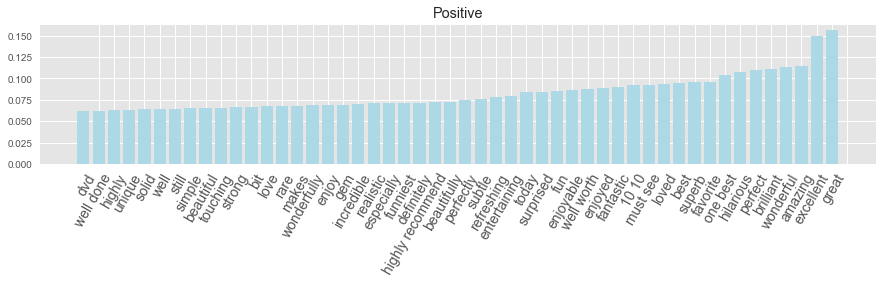

In [30]:
visualize_coefficients(logit_cv.coef_[0,:], tf_vectorizer.get_feature_names(),title="Positive", plot_num=0, n_top_features=50)

In [31]:
def visualize_coefficients_2(coef, feature_names, title, plot_num, n_top_features=50):
    interesting_coefficients = np.argsort(coef)[0:n_top_features]
    
    plt.figure(figsize=(15, 15))
    plt.subplot(510+plot_num+1)
    colors = ["lightblue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

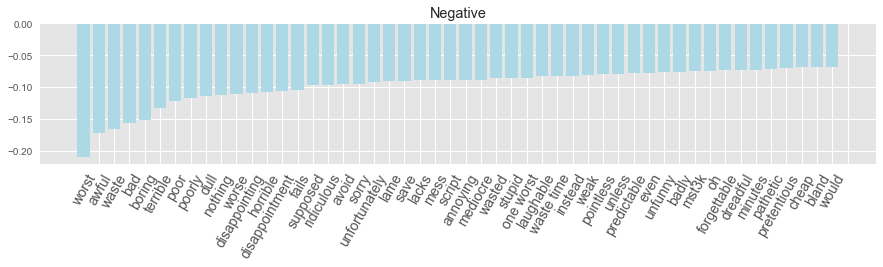

In [32]:
visualize_coefficients_2(logit_cv.coef_[0,:], tf_vectorizer.get_feature_names(),title="Negative", plot_num=1, n_top_features=50)